In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/creditcardfraud/creditcard.csv


In [2]:
## data analysis for credit_card frauds 

In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

In [4]:
df_cred=pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")

In [5]:
df_cred.shape

(284807, 31)

In [6]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
import warnings
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

warnings.filterwarnings('ignore')

from contextlib import contextmanager

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))


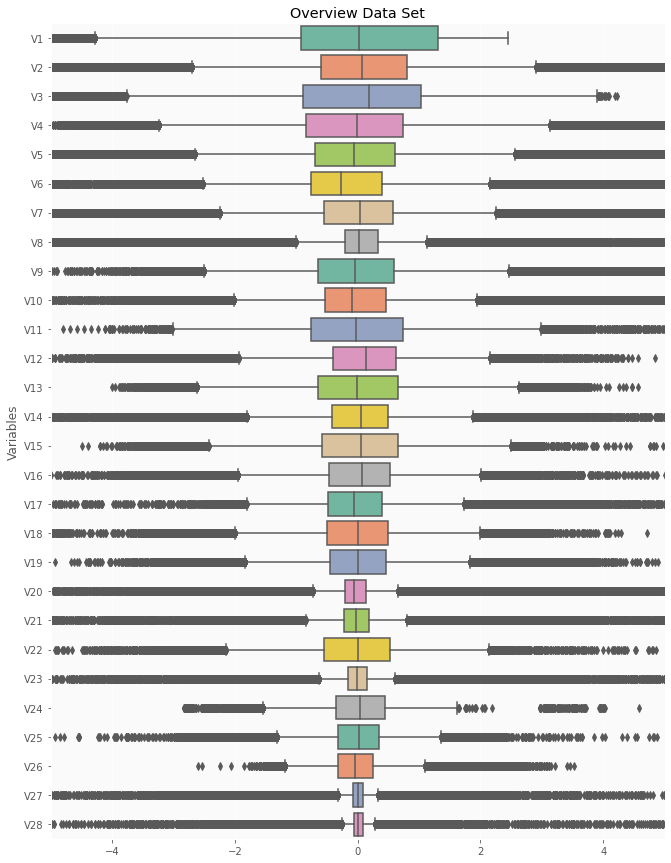

In [7]:
plt.style.use('ggplot') # Using ggplot2 style visuals 

f, ax = plt.subplots(figsize=(11, 15))

ax.set_facecolor('#fafafa')
ax.set(xlim=(-5, 5))
plt.ylabel('Variables')
plt.title("Overview Data Set")
ax = sns.boxplot(data = df_cred.drop(columns=['Amount', 'Class', 'Time']), 
  orient = 'h', 
  palette = 'Set2')

In [8]:
fraud = df_cred[(df_cred['Class'] != 0)]
normal = df_cred[(df_cred['Class'] == 0)]

trace = go.Pie(labels = ['Normal', 'Fraud'], values = df_cred['Class'].value_counts(), 
               textfont=dict(size=15), opacity = 0.8,
               marker=dict(colors=['lightskyblue','gold'], 
                           line=dict(color='#000000', width=1.5)))


layout = dict(title =  'Distribution of target variable')
           
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

## As we can see fraud cases are negligible and we have to build model to detect anamolies 

## so i will be building auto-encoder first in keras then for production level code i will be building it in
## tensorflow and finally in tensorflow serving API for it's deployment 
## will post github link it it

## Feature distribution

In [9]:
# Def plot distribution
def plot_distribution(data_select) : 
    figsize =( 15, 8)
    sns.set_style("ticks")
    s = sns.FacetGrid(df_cred, hue = 'Class',aspect = 2.5, palette ={0 : 'lime', 1 :'black'})
    s.map(sns.kdeplot, data_select, shade = True, alpha = 0.6)
    s.set(xlim=(df_cred[data_select].min(), df_cred[data_select].max()))
    s.add_legend()
    s.set_axis_labels(data_select, 'proportion')
    s.fig.suptitle(data_select)
    plt.show()

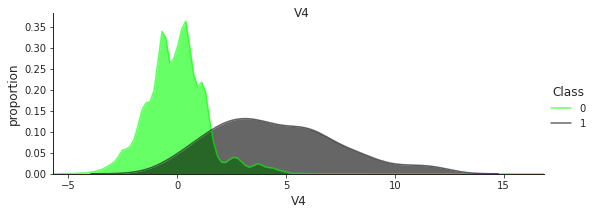

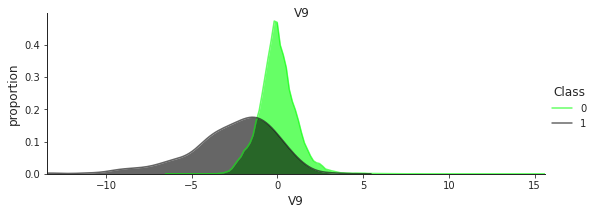

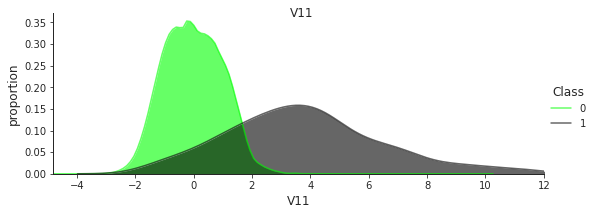

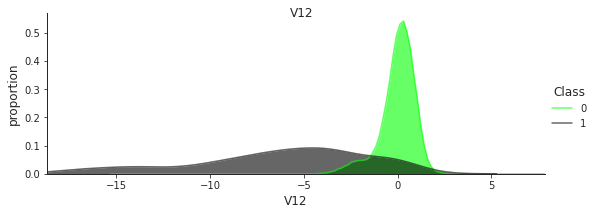

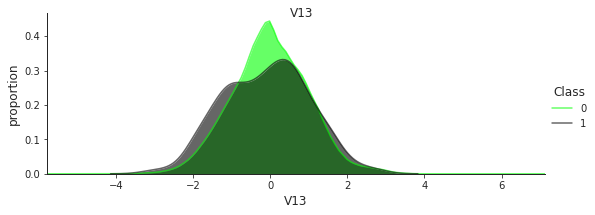

In [10]:
plot_distribution('V4')
plot_distribution('V9')
plot_distribution('V11')
plot_distribution('V12')
plot_distribution('V13')

### data preprocessing it requires normalization why normalization 
### whenever we are seeing multiple features which are different ranges of distributions
### then we should prefer normalization if same range every feature but still lot of within range distribution
### we should give it standardization

### Now big question why auto-encoder for classification ? 
### how it is possible that neural network which is used for recontruction of input values can be used as a classifier for fraud transcations

![](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQ5aL46qJsIl3AjFoOLyNbn_vdLe2a2tPns9-PikUI8EhpaLTJx&usqp=CAU)


### so answer to this curiousity is very simple 
### as we know autoencoder is useful for reconstruciton of values 
### but if I train it on non-fraudulent transaction then it will be able to contruct non-fraudlent only
### so if I pass fraudulent transaction with non-fraudulent one then mse will be high for fraud transaction one
### why because it's weight are made on the basis of non-fraudulent transaction 
### then at last I will decide a perfect threshold for classify fraudulent vs non-fraudulent transaction 

# Initial Preprocessing 

In [11]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , roc_auc_score, roc_curve

In [12]:
### dropping off unncessary columns

In [13]:
min_max_scaler = preprocessing.MinMaxScaler()
df_cred=df_cred.drop("Time",axis=1)
df_cred_scaled = min_max_scaler.fit_transform(df_cred.iloc[:,:-1])
df_cred_normalized = pd.DataFrame(df_cred_scaled)

In [14]:
df_cred_normalized["Class"]=df_cred["Class"]

In [15]:
df_cred_normalized["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

# Spliting strategy


### 20% percent in test set of 0 class then 10% in validation set of class 0 
### as we know in training label 1 class will not go but to decide the threshold of mse so that we can 
### classify anomaly perfectly so 50% of the 1 class percent we will be in test set rest 50% in validate set 
(of course class 0 will be there too with class 1 in both sets validation and test)

In [16]:
df_cred_normalized_train=df_cred_normalized[df_cred_normalized["Class"]==0]
df_cred_normalized_test=df_cred_normalized[df_cred_normalized["Class"]==1]

#### splitting dataset as per strategy I have dicussed 
#### we will train it on non-fraudulent transcation and test on both the classes 


In [17]:
df_cred_normalized_test_part_1=df_cred_normalized_train.sample(frac=0.05)
df_cred_normalized_train=df_cred_normalized_train.drop(df_cred_normalized_test_part_1.index)
df_cred_normalized_test_part_2=df_cred_normalized_train.sample(frac=0.05)
df_cred_normalized_train=df_cred_normalized_train.drop(df_cred_normalized_test_part_2.index)

### removing of fractional subset from main train set done 
### now starting up with making of test and validation set 

In [18]:
df_cred_normalized_test_class_1=df_cred_normalized_test.sample(frac=0.5)
df_cred_normalized_validation_class_1=df_cred_normalized_test.drop(df_cred_normalized_test_class_1.index)

In [19]:
df_cred_normalized_test_class_1.shape

(246, 30)

## Merging of test and validation sets 

In [20]:
df_cred_normalized_test_set=df_cred_normalized_test_part_1.append(df_cred_normalized_test_class_1)
df_cred_normalized_validation_set=df_cred_normalized_test_part_2.append(df_cred_normalized_validation_class_1)

### just re-checking size of train test and validate set 

In [21]:
print("train set dimensions :",df_cred_normalized_train.shape)
print("test set dimensions :",df_cred_normalized_test_set.shape)
print("validate set dimensions :",df_cred_normalized_validation_set.shape)

train set dimensions : (256594, 30)
test set dimensions : (14462, 30)
validate set dimensions : (13751, 30)


In [22]:
df_cred_normalized_validation_set["Class"].value_counts()

0    13505
1      246
Name: Class, dtype: int64

### still need some small part of training set in testing of autoencoder network for reconstruction of values

In [23]:
X_train, X_test = train_test_split(df_cred_normalized_train, test_size=0.2, random_state=2020)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train.values
X_test = X_test.values
X_train.shape

(205275, 29)

# Autoencoder here we go 

In [24]:
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.callbacks import EarlyStopping ,ReduceLROnPlateau
from keras.optimizers import Adam

#from keras import regularizers

Using TensorFlow backend.


# What type of activations ?

Linear: Autoencoders with a single hidden layer with k hidden neurons and linear activations create equivalent representations to PCA with k principal components.

Binary: It is often used as introduction to ANN and not in real world applications.

ReLU: Rectified linear units are widely used in deep learning models. However, they are not suitable for AEs because they distort the decoding process by outputting 0 for negative inputs and consequently, do not lead to faithful representations of the input features.

SELU: Scaled exponential linear units activation function is a formidable alternative to ReLU as it preserves the advantages of linearly passing the positive inputs while it enables the flow of negative too.
Sigmoid: The most commonly used activation function for autoencoders.

Tanh: Hyperbolic tangent is similar to sigmoid with the difference that is symmetric to the origin and its slope is steeper. As a result, it produces stronger gradients than sigmoid and should be preferred.


In [25]:
input_dim = X_train.shape[1]
encoding_dim = 20
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim*2, activation="sigmoid")(input_layer)
encoder = Dense(encoding_dim, activation="sigmoid")(input_layer)
encoder = Dense(8,activation="sigmoid")(encoder)
decoder = Dense(20, activation='sigmoid')(encoder)
decoder = Dense(40, activation='sigmoid')(encoder)
decoder = Dense(input_dim, activation='sigmoid')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

### Generally MSE as loss function but why , Mae we can use too or not?

### after 22 epochs we achieved plateaue and accuracy of 99.23 in reconstruction on test data 

In [26]:
nb_epoch = 50
batch_size = 32
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=15)

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),callbacks=[es,checkpointer],
                    verbose=1)

Train on 205275 samples, validate on 51319 samples
Epoch 1/50
205275/205275 [==============================] - 26s 125us/step - loss: 0.0019 - accuracy: 0.9813 - val_loss: 0.0012 - val_accuracy: 0.9917
Epoch 2/50
205275/205275 [==============================] - 24s 119us/step - loss: 8.6690e-04 - accuracy: 0.9923 - val_loss: 6.7825e-04 - val_accuracy: 0.9917
Epoch 3/50
205275/205275 [==============================] - 26s 125us/step - loss: 5.8483e-04 - accuracy: 0.9923 - val_loss: 4.9097e-04 - val_accuracy: 0.9917
Epoch 4/50
205275/205275 [==============================] - 24s 117us/step - loss: 4.1292e-04 - accuracy: 0.9923 - val_loss: 3.7000e-04 - val_accuracy: 0.9917
Epoch 5/50
205275/205275 [==============================] - 26s 125us/step - loss: 3.6000e-04 - accuracy: 0.9923 - val_loss: 3.6613e-04 - val_accuracy: 0.9917
Epoch 6/50
205275/205275 [==============================] - 24s 118us/step - loss: 3.5635e-04 - accuracy: 0.9923 - val_loss: 3.6067e-04 - val_accuracy: 0.9917
Epo

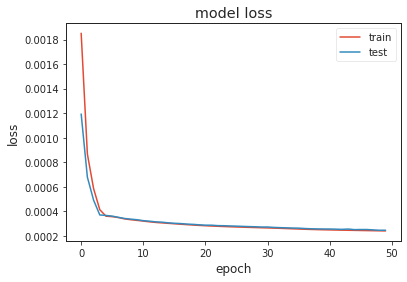

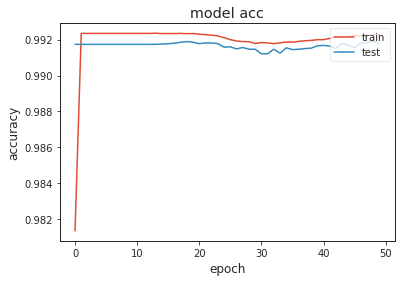

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### reconstruction error on x_test set

In [28]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

,reconstruction_error,true_class
count,51319.000000,51319.0
mean,0.000246,0.0
std,0.001024,0.0
min,0.000011,0.0
25%,0.000092,0.0
50%,0.000147,0.0
75%,0.000244,0.0
max,0.191015,0.0


### as you can std deviation is not so much varying while reconstruction of training data 
### as far as we are good to go for testing of out main test set and validation set 
### after that we can develope our same model in Tensorflow using TF records for mainline production 


# Evaluation of mse on both classes on test set

In [29]:
y_test=df_cred_normalized_test_set["Class"]
df_cred_normalized_test_set=df_cred_normalized_test_set.drop("Class",axis=1)

In [30]:
predictions = autoencoder.predict(df_cred_normalized_test_set)
mse = np.mean(np.power(df_cred_normalized_test_set - predictions, 2), axis=1)
error_df_test = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df_test.describe()

,reconstruction_error,true_class
count,14462.000000,14462.000000
mean,0.000477,0.017010
std,0.002731,0.129313
min,0.000018,0.000000
25%,0.000093,0.000000
50%,0.000150,0.000000
75%,0.000255,0.000000
max,0.067655,1.000000


### now checking how much reconstruction error present in class 0 and class 1

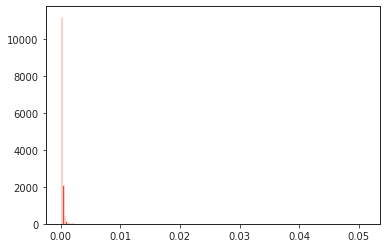

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df_test[(error_df_test['true_class']== 0) & (error_df_test['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=200)

### very small mse will be present we are concerned for deciding the threshold in test set

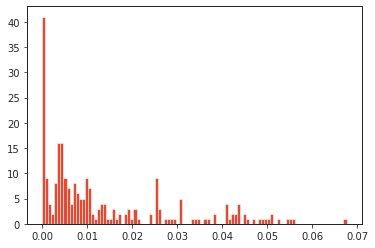

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df_test[error_df_test['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=100)


### as we can see that from both graphs MSE for fraudulent cases is x10 times > Non-fraudulent cases 

In [33]:
fraud_error_df.describe() ### frauds cases 

,reconstruction_error,true_class
count,246.000000,246.0
mean,0.013627,1.0
std,0.015128,0.0
min,0.000051,1.0
25%,0.003276,1.0
50%,0.007354,1.0
75%,0.020510,1.0
max,0.067655,1.0


In [34]:
normal_error_df.describe() ### non fraud cases

,reconstruction_error,true_class
count,14216.000000,14216.0
mean,0.000249,0.0
std,0.000773,0.0
min,0.000018,0.0
25%,0.000092,0.0
50%,0.000148,0.0
75%,0.000248,0.0
max,0.051072,0.0


#### selection of threshold as you can see max is 0.02 but if you observed 3rd quartile range it is really very small in comparison to max one which indicates that in selection of threshold we should not take max into the account because mean value of mse in frauds cases is 0.012 with std of 0.013 
#### even minimum value of mse in normal transaction is range of minima of fraud cases but it's mse approx 30% is higher from normal transaction

#### so these cases which i saw are very much corner cases means and at extreme points to be get classified correctly

In [35]:
error_df_test["predicted_class"]=[1 if x > 0.001 else 0 for x in error_df_test["reconstruction_error"]]

In [36]:
error_df_test

,reconstruction_error,true_class,predicted_class
1961,0.000098,0,0
25902,0.000026,0,0
37658,0.000103,0,0
162009,0.000177,0,0
22852,0.000208,0,0
...,...,...,...
235644,0.007745,1,1
263274,0.009954,1,1
83417,0.010148,1,1
156990,0.006237,1,1


#### let's present our evaluation metrics over the threshold we have decided

In [37]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

In [38]:
error_df_test["predicted_class"]=[1 if x > 0.001 else 0 for x in error_df_test["reconstruction_error"]]

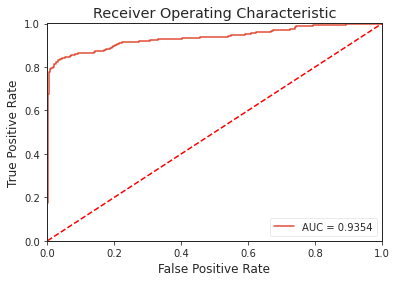

In [39]:
fpr, tpr, thresholds = roc_curve(error_df_test.true_class, error_df_test.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

In [40]:
print(classification_report(error_df_test["true_class"],error_df_test["predicted_class"]))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     14216
           1       0.39      0.81      0.53       246

    accuracy                           0.98     14462
   macro avg       0.69      0.90      0.76     14462
weighted avg       0.99      0.98      0.98     14462



### now question comes up why precision is so low while recall is high 
### see we are actually testing imbalance test but in real world frauds cases will be 
### like this so what should we do ?
### focus on precision why see we can't catch every fraud but what we can catch as fraud case should be fraud to save company's money and customer as well

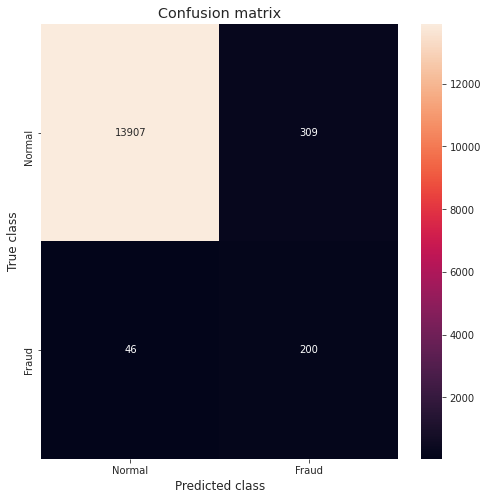

In [41]:
LABELS = ["Normal", "Fraud"]
y_pred = [1 if e > 0.004 else 0 for e in error_df_test.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df_test.true_class,error_df_test.predicted_class)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

### so conclusion that out of 246 fraud cases 209 we were able to classify correctly 
### and normal transaction 352 cases model declaring them as fraud out of 14k cases
### so here threshold is making final model is like that 85 percent cases model can detect but it not precise so much , means model yes or no has no value , only what model can do is put those cases in suspect but can't bring final conclusions

## *Stats can might change after running the kernel but it will approximate to those which were stated earlier

## now thershold is changed to focus on precision as primary


In [42]:
error_df_test["predicted_class"]=[1 if x > 0.0039888 else 0 for x in error_df_test["reconstruction_error"]]

In [43]:
print(classification_report(error_df_test["true_class"],error_df_test["predicted_class"]))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     14216
           1       0.78      0.67      0.72       246

    accuracy                           0.99     14462
   macro avg       0.89      0.84      0.86     14462
weighted avg       0.99      0.99      0.99     14462



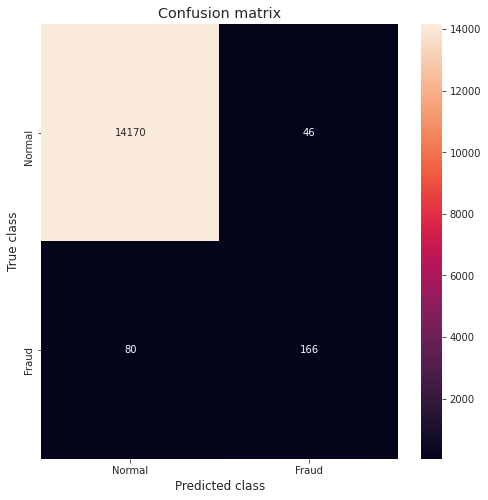

In [44]:
LABELS = ["Normal", "Fraud"]
y_pred = [1 if e >  0.0039888 else 0 for e in error_df_test.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df_test.true_class,error_df_test.predicted_class)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

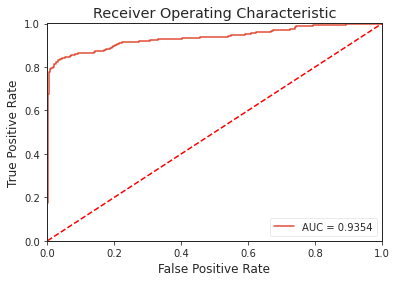

In [45]:
fpr, tpr, thresholds = roc_curve(error_df_test.true_class, error_df_test.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

### our roc-curve is telling that our model is doing really great in classifying both the classes
### but one should never forget sample size of test cases are imbalanced so always precision and recall 
### before deploying the model in real world 

### now same for final evaluation set that is our validation-set

In [46]:
y_test=df_cred_normalized_validation_set["Class"]
df_cred_normalized_validation_set=df_cred_normalized_validation_set.drop("Class",axis=1)
predictions = autoencoder.predict(df_cred_normalized_validation_set)
mse = np.mean(np.power(df_cred_normalized_validation_set - predictions, 2), axis=1)
error_df_test = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df_test.describe()

,reconstruction_error,true_class
count,13751.000000,13751.000000
mean,0.000487,0.017890
std,0.002863,0.132555
min,0.000016,0.000000
25%,0.000093,0.000000
50%,0.000149,0.000000
75%,0.000250,0.000000
max,0.068355,1.000000


In [47]:
error_df_test["predicted_class"]=[1 if x > 0.003 else 0 for x in error_df_test["reconstruction_error"]]

In [48]:
print(classification_report(error_df_test["true_class"],error_df_test["predicted_class"]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13505
           1       0.78      0.77      0.77       246

    accuracy                           0.99     13751
   macro avg       0.89      0.88      0.88     13751
weighted avg       0.99      0.99      0.99     13751



### our model is performing really well even on validaiton dataset on fraud cases better than test set

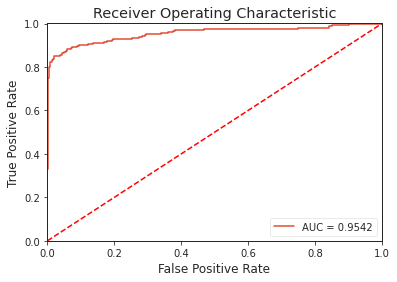

In [49]:
fpr, tpr, thresholds = roc_curve(error_df_test.true_class, error_df_test.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

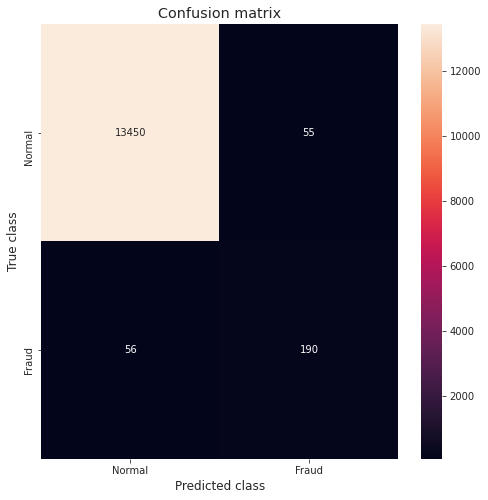

In [50]:
LABELS = ["Normal", "Fraud"]
y_pred = [1 if e >  0.00398888 else 0 for e in error_df_test.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df_test.true_class,error_df_test.predicted_class)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()